# 🏢 Employee Attrition Prediction – Enhanced Analysis  
**Objective:** Build multiple explainable ML models to predict employee attrition, compare their performance, interpret them with SHAP ‑ and provide actionable HR insights.  
Dataset: **IBM HR Analytics Employee Attrition & Performance**

In [1]:

!pip -q install pandas numpy matplotlib seaborn scikit-learn shap xgboost lime --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import shap, lime.lime_tabular
sns.set(style='whitegrid')


In [3]:
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


(1470, 35)
Attrition
No     1233
Yes     237
Name: count, dtype: int64


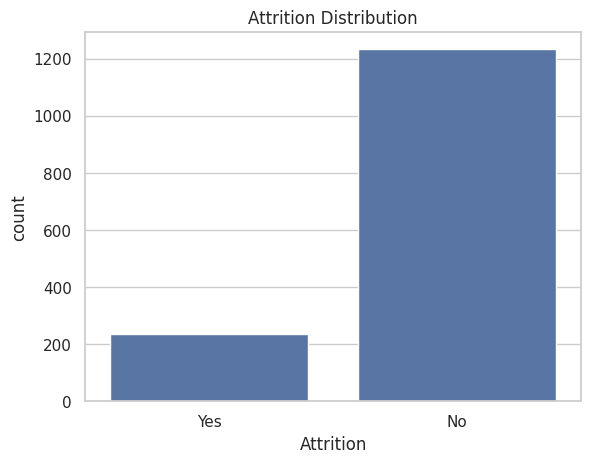

In [4]:
print(df.shape); print(df['Attrition'].value_counts())
sns.countplot(data=df, x='Attrition'); plt.title('Attrition Distribution'); plt.show()


In [5]:
le = LabelEncoder()
df_enc = df.apply(lambda c: le.fit_transform(c) if c.dtype=='object' else c)
X = df_enc.drop('Attrition', axis=1)
y = df_enc['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [13]:
def evaluate(name, y_true, y_pred, y_prob):
    print(f'\n{name} classification report:')
    print(classification_report(y_true, y_pred, target_names=['Stay','Leave']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Stay','Leave'], yticklabels=['Stay','Leave'])
    plt.title(f'{name} – Confusion Matrix'); plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_true, y_prob):.3f}')
    plt.plot([0,1],[0,1],'--'); plt.title(f'{name} – ROC'); plt.legend(); plt.show()
    return {'Model':name,
            'Accuracy':accuracy_score(y_true, y_pred),
            'Precision':precision_score(y_true, y_pred),
            'Recall':recall_score(y_true, y_pred),
            'F1':f1_score(y_true, y_pred),
            'ROC-AUC':roc_auc_score(y_true, y_prob)}


LogisticRegression classification report:
              precision    recall  f1-score   support

        Stay       0.90      0.66      0.76       247
       Leave       0.26      0.62      0.36        47

    accuracy                           0.65       294
   macro avg       0.58      0.64      0.56       294
weighted avg       0.80      0.65      0.70       294



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


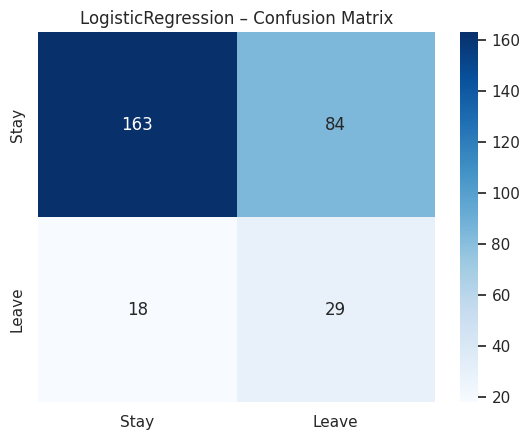

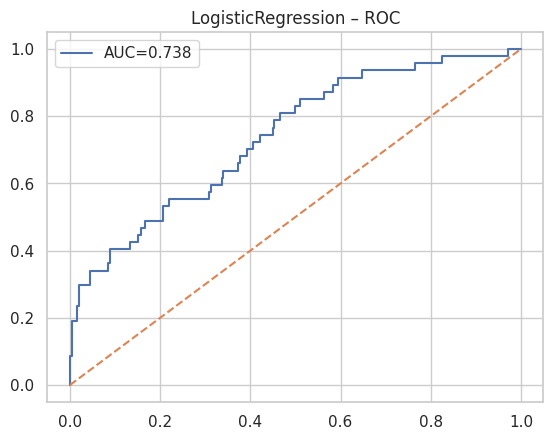

In [14]:
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced')
log_clf.fit(X_train, y_train)
log_pred, log_prob = log_clf.predict(X_test), log_clf.predict_proba(X_test)[:,1]
log_metrics = evaluate('LogisticRegression', y_test, log_pred, log_prob)



RandomForest classification report:
              precision    recall  f1-score   support

        Stay       0.85      0.98      0.91       247
       Leave       0.38      0.06      0.11        47

    accuracy                           0.83       294
   macro avg       0.61      0.52      0.51       294
weighted avg       0.77      0.83      0.78       294



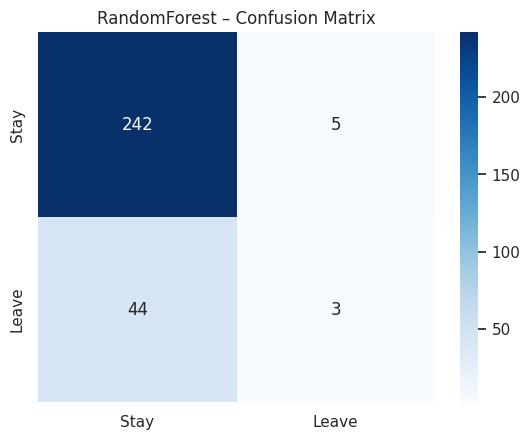

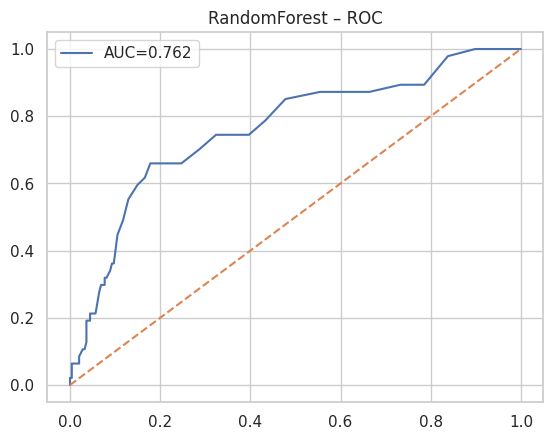

Best RF params: {'max_depth': None, 'n_estimators': 100}


In [15]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
params = {'n_estimators':[100,200], 'max_depth':[None,10,20]}
g_rf = GridSearchCV(rf, params, cv=3, scoring='roc_auc', n_jobs=-1)
g_rf.fit(X_train, y_train)
best_rf = g_rf.best_estimator_
rf_pred, rf_prob = best_rf.predict(X_test), best_rf.predict_proba(X_test)[:,1]
rf_metrics = evaluate('RandomForest', y_test, rf_pred, rf_prob)
print('Best RF params:', g_rf.best_params_)



GradientBoosting classification report:
              precision    recall  f1-score   support

        Stay       0.86      0.97      0.91       247
       Leave       0.56      0.19      0.29        47

    accuracy                           0.85       294
   macro avg       0.71      0.58      0.60       294
weighted avg       0.82      0.85      0.81       294



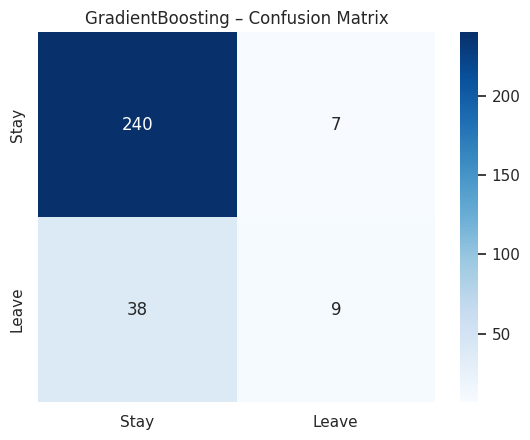

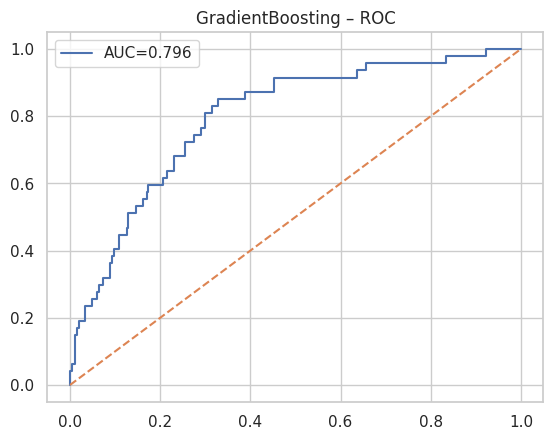

In [16]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred, gb_prob = gb.predict(X_test), gb.predict_proba(X_test)[:,1]
gb_metrics = evaluate('GradientBoosting', y_test, gb_pred, gb_prob)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:03:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost classification report:
              precision    recall  f1-score   support

        Stay       0.87      0.96      0.91       247
       Leave       0.55      0.23      0.33        47

    accuracy                           0.85       294
   macro avg       0.71      0.60      0.62       294
weighted avg       0.82      0.85      0.82       294



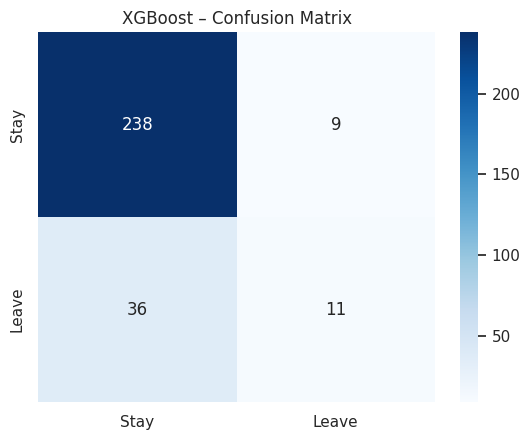

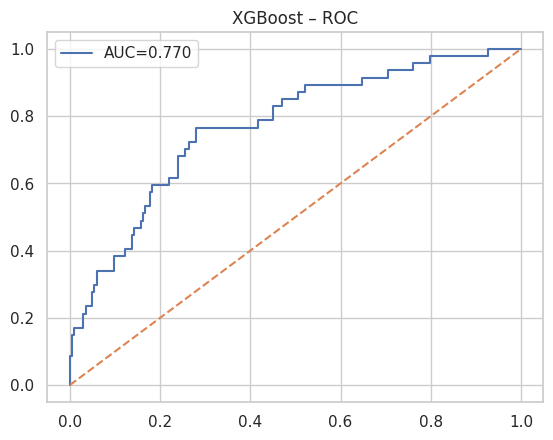

In [17]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb_pred, xgb_prob = xgb.predict(X_test), xgb.predict_proba(X_test)[:,1]
xgb_metrics = evaluate('XGBoost', y_test, xgb_pred, xgb_prob)


In [18]:
import pandas as pd
results = pd.DataFrame([log_metrics, rf_metrics, gb_metrics, xgb_metrics]).set_index('Model')
results


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
LogisticRegression,0.653061,0.256637,0.617021,0.362500,0.738393
RandomForest,0.833333,0.375000,0.063830,0.109091,0.761823
GradientBoosting,0.846939,0.562500,0.191489,0.285714,0.796365
XGBoost,0.846939,0.550000,0.234043,0.328358,0.770092


/tmp/ipython-input-23-3274551874.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


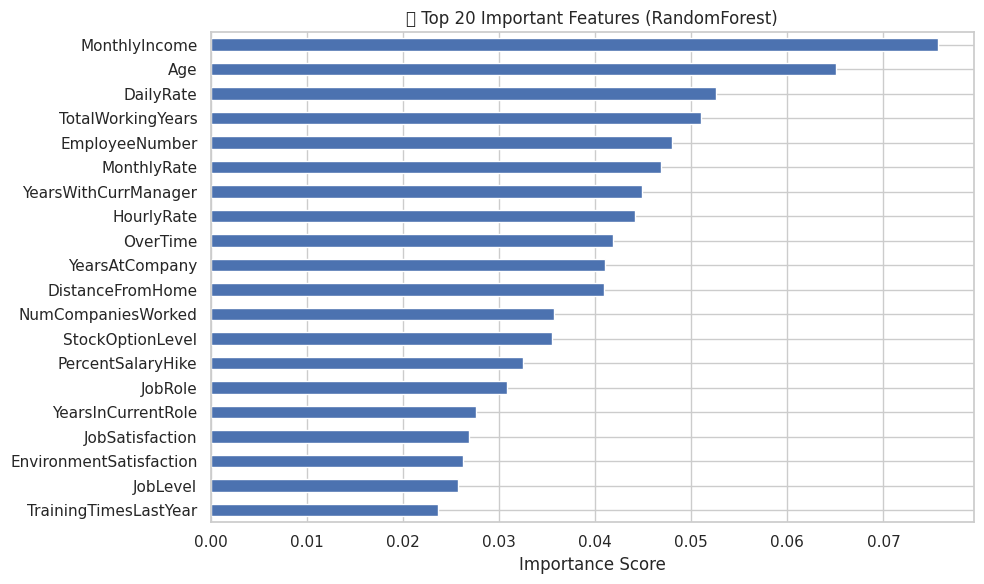

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances from RandomForest
importances = best_rf.feature_importances_
feat_names = X.columns

# Plot
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,6))
feat_imp.plot(kind='barh')
plt.title("🔍 Top 20 Important Features (RandomForest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [26]:
lime_exp = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns,
                                                  class_names=['Stay','Leave'], discretize_continuous=True)
exp = lime_exp.explain_instance(sample.values[0], best_rf.predict_proba, num_features=10)
exp.show_in_notebook()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='roc_auc')
print('RF 5‑fold ROC‑AUC:', cv_scores.mean(), '±', cv_scores.std())


RF 5‑fold ROC‑AUC: 0.8025315680573033 ± 0.02215438482523128
